- [18.1 - Multiple Linear Regression](#18.1---Multiple-Linear-Regression)
 - [18.1.4 - Redundant predictors](#18.1.4---Redundant-predictors)
- [18.2 - Multiplicative Interaction of Metric Predictors](#18.2---Multiplicative-Interaction-of-Metric-Predictors)
- [18.3 - Shrinkage of Regression Coefficients](#18.3---Shrinkage-of-Regression-Coefficients)
- [18.4 - Variable Selection](#18.4---Variable-Selection)
 - [18.4.2 - Variable selection with hierarchical shrinkage](#18.4.2---Variable-Selection-with-hierarchical-shrinkage)

## Chapter 18 - Metric Predicted Variable with Multiple Metric Predictors

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from scipy.stats import mode, norm, t
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [266]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, point_est='mode', burnin=0, y_labels=False, ax=None):
       
    color = '#87ceeb'
    font_d = {'size':14}
    
    if ax == None:
        ax = plt.gca()
               
    hpd_interval = np.round(pmc.hpd(dist[burnin:], alpha=alpha), decimals=decimals)
        
    # Histogram, Mode/Mean
    sns.distplot(dist[burnin:], kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    
    if point_est == 'mode':
        p_est_value = mode(np.round(dist[burnin:], decimals=decimals))[0][0]
    else:
        p_est_value = np.round(np.mean(dist[burnin:]), decimals=decimals)
    
    ax.text(p_est_value, plot_height*.9, '{} = {}'.format(point_est, p_est_value),
            horizontalalignment='center', fontdict=font_d, clip_on=False)    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict=font_d)
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict=font_d)

    # Reference line
    if vert_ref is None:
        ax.axvline(p_est_value, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### 18.1 - Multiple Linear Regression
#### Data

In [3]:
df = pd.read_csv('data/Guber1999data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
State        50 non-null object
Spend        50 non-null float64
StuTeaRat    50 non-null float64
Salary       50 non-null float64
PrcntTake    50 non-null int64
SATV         50 non-null int64
SATM         50 non-null int64
SATT         50 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [4]:
df.head()

        State  Spend  StuTeaRat  Salary  PrcntTake  SATV  SATM  SATT
0     Alabama  4.405       17.2  31.144          8   491   538  1029
1      Alaska  8.963       17.6  47.951         47   445   489   934
2     Arizona  4.778       19.3  32.175         27   448   496   944
3    Arkansas  4.459       17.1  28.934          6   482   523  1005
4  California  4.992       24.0  41.078         45   417   485   902

In [5]:
X = df[['Spend', 'PrcntTake']]
y = df['SATT']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

meany = y.mean()
scaley = y.std()
zy = ((y-meany)/scaley).values

#### Model (Kruschke, 2015)

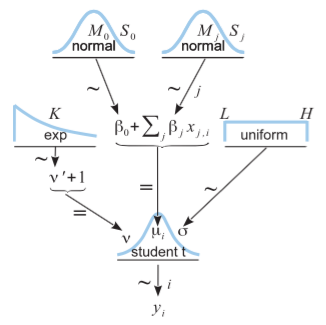

In [6]:
Image('images/fig18_4.png', width=400)

In [124]:
with pmc.Model() as model:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(2))
    zmu =  zbeta0 + pmc.dot(zbetaj, zX.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [194]:
with model:
    trace = pmc.sample(10000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 91.4 sec

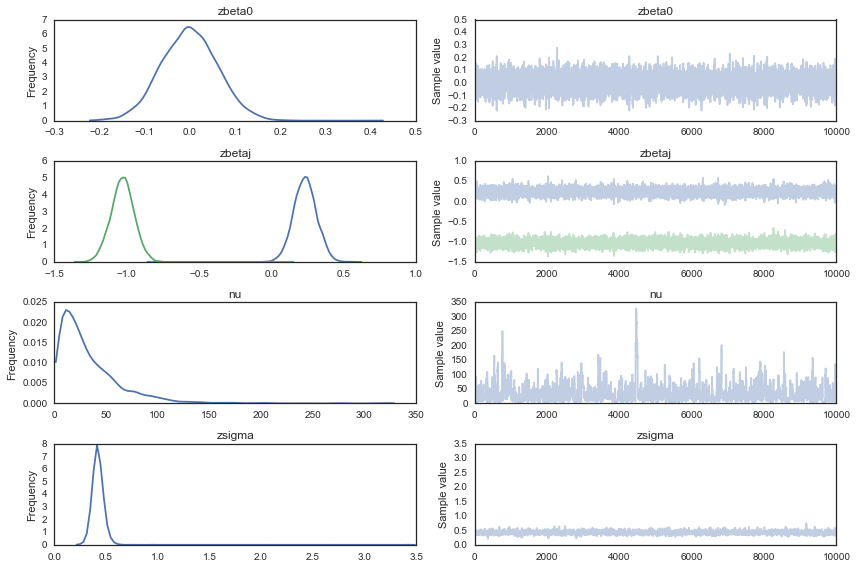

In [195]:
pmc.traceplot(trace);

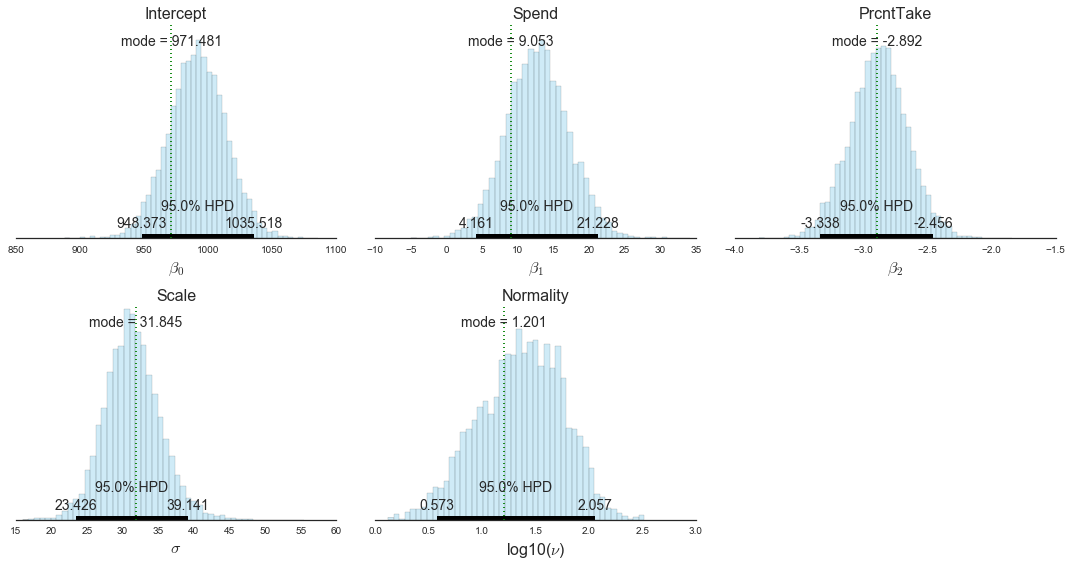

In [196]:
# Transform parameters back to original scale
beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['zbetaj']*meanx/scalex, axis=1)*scaley
betaj = (trace['zbetaj']/scalex)*scaley
scale = trace['zsigma']*scaley

intercept = beta0
spend = betaj[:,0]
prcnttake =  betaj[:,1]
normality = np.log10(trace['nu'])
burnin = 100

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(15,8))

plot_posterior(intercept[burnin:], ax=ax1)
ax1.set_title('Intercept', fontdict=f_dict)
ax1.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(spend[burnin:], ax=ax2)
ax2.set_title('Spend', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_1$', fontdict=f_dict)

plot_posterior(prcnttake[burnin:], ax=ax3)
ax3.set_title('PrcntTake', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_2$', fontdict=f_dict)

plot_posterior(scale[burnin:], ax=ax4)
ax4.set_title('Scale', fontdict=f_dict)
ax4.set_xlabel(r'$\sigma$', fontdict=f_dict)

plot_posterior(normality[burnin:], ax=ax5)
ax5.set_title('Normality', fontdict=f_dict)
ax5.set_xlabel(r'log10($\nu$)', fontdict=f_dict)

plt.tight_layout()

ax6.set_visible(False)

Below we create the scatterplots of figure 18.5 using `pairplot()` in seaborn and then tweak the lower triangle.

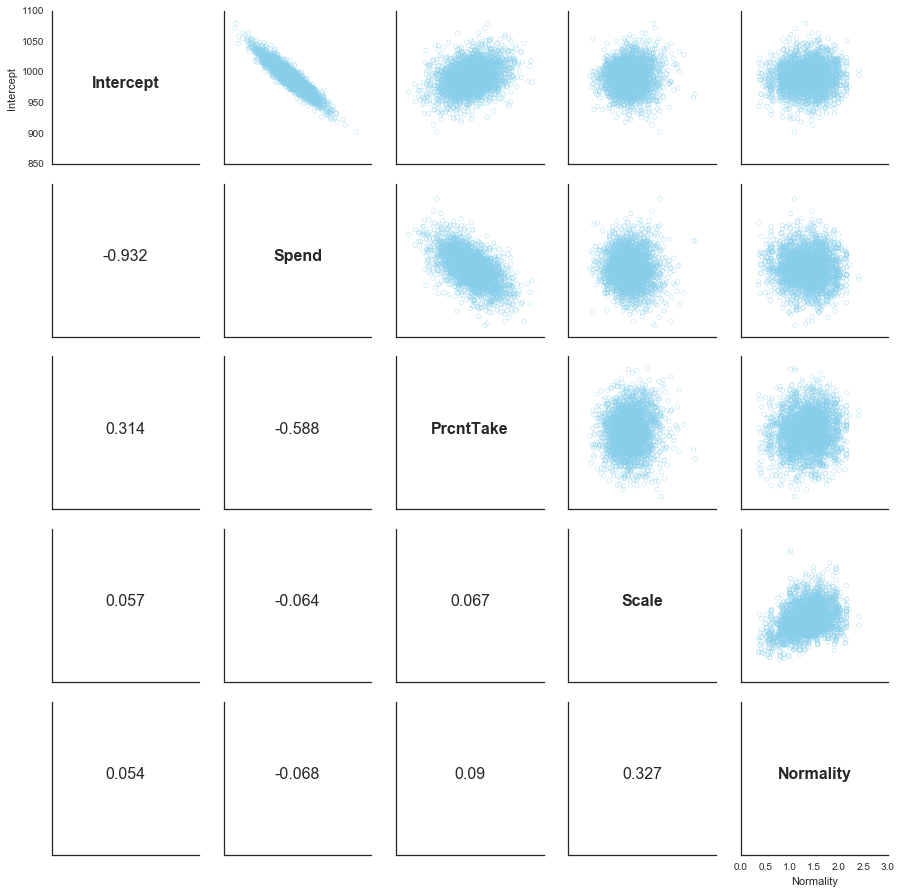

In [128]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept,
                         'Spend':spend,
                         'PrcntTake': prcnttake,
                         'Scale':scale,
                         'Normality': normality},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt.iloc[burnin:,:], rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt.iloc[burnin:,:], plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

### 18.1.4 - Redundant predictors

In [160]:
X2 = X.assign(PropNotTake = lambda x: (100-x.PrcntTake)/100)

meanx2 = X2.mean().values
scalex2 = X2.std().values
zX2 = ((X2-meanx2)/scalex2).values

In [161]:
with pmc.Model() as model2:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(3))
    zmu =  zbeta0 + pmc.dot(zbetaj, zX2.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)
    

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [198]:
with model2:
    trace2 = pmc.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 5000 of 5000 complete in 87.8 sec

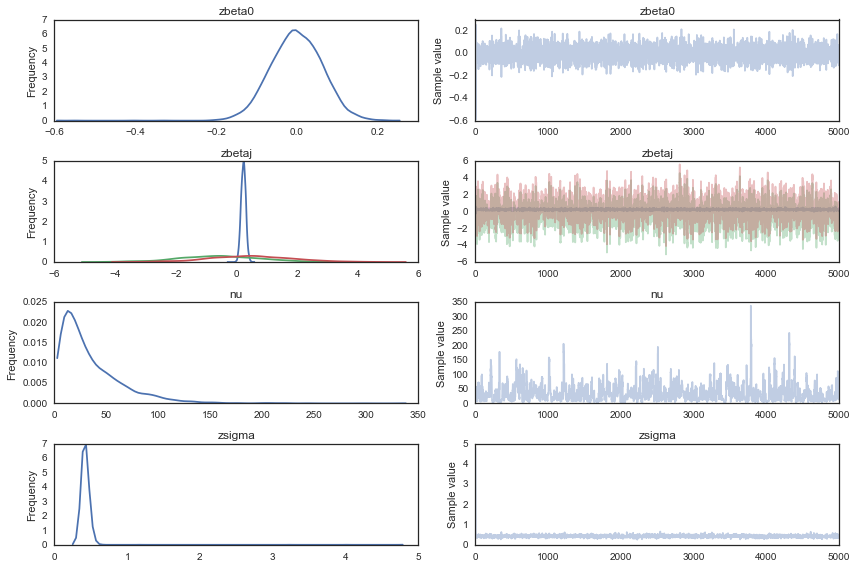

In [199]:
pmc.traceplot(trace2);

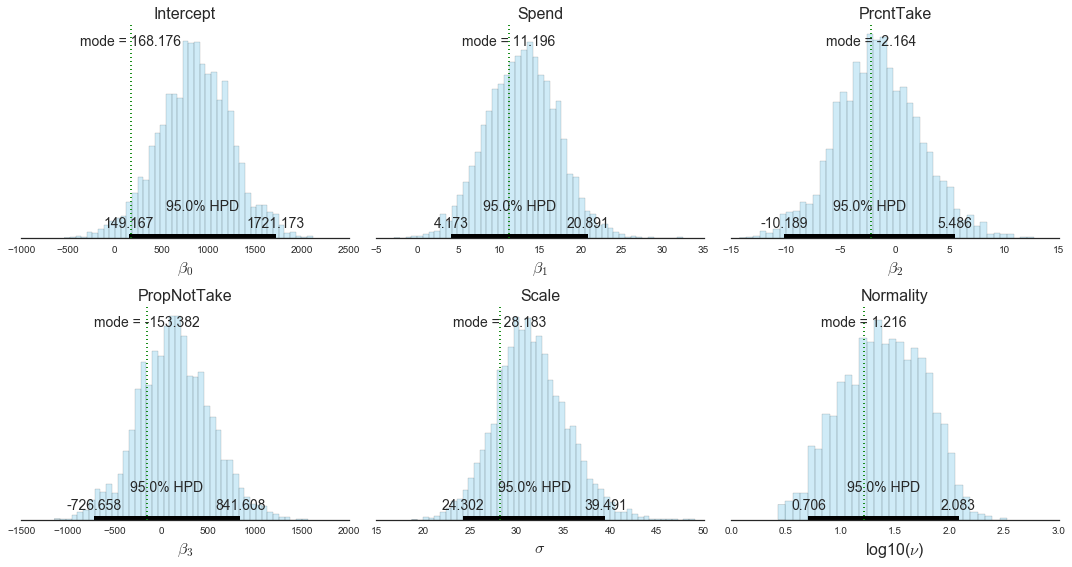

In [200]:
# Transform parameters back to original scale
beta0 = trace2['zbeta0']*scaley + meany - np.sum(trace2['zbetaj']*meanx2/scalex2, axis=1)*scaley
betaj = (trace2['zbetaj']/scalex2)*scaley
scale = trace2['zsigma']*scaley

intercept = beta0
spend = betaj[:,0]
prcnttake =  betaj[:,1]
propnottake =  betaj[:,2]
normality = np.log10(trace2['nu'])
burnin = 200

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(15,8))

plot_posterior(intercept[burnin:], ax=ax1)
ax1.set_title('Intercept', fontdict=f_dict)
ax1.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(spend[burnin:], ax=ax2)
ax2.set_title('Spend', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_1$', fontdict=f_dict)

plot_posterior(prcnttake[burnin:], ax=ax3)
ax3.set_title('PrcntTake', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_2$', fontdict=f_dict)

plot_posterior(propnottake[burnin:], ax=ax4)
ax4.set_title('PropNotTake', fontdict=f_dict)
ax4.set_xlabel(r'$\beta_3$', fontdict=f_dict)

plot_posterior(scale[burnin:], ax=ax5)
ax5.set_title('Scale', fontdict=f_dict)
ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)

plot_posterior(normality[burnin:], ax=ax6)
ax6.set_title('Normality', fontdict=f_dict)
ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)

plt.tight_layout()

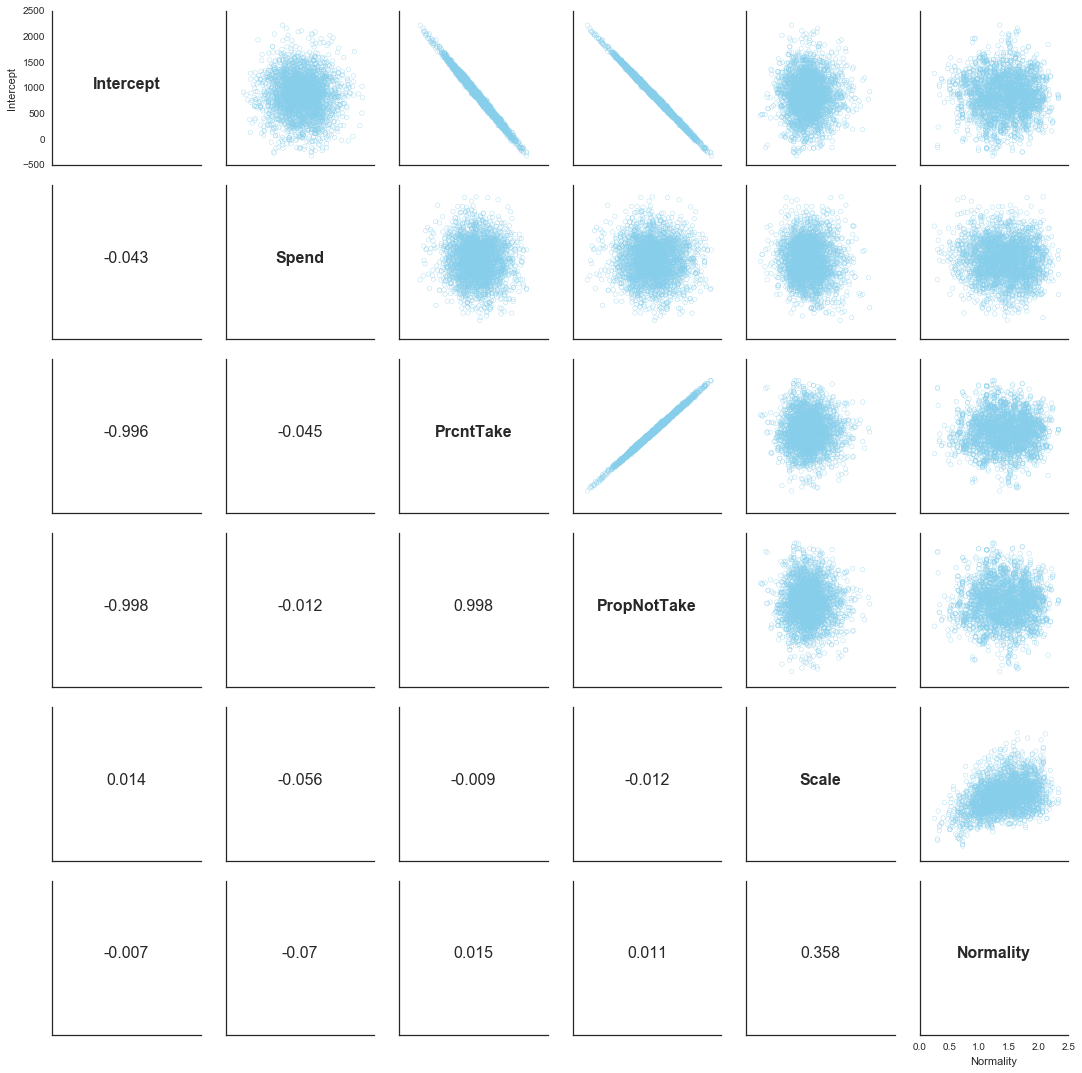

In [165]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept,
                         'Spend':spend,
                         'PrcntTake': prcnttake,
                         'PropNotTake': propnottake,
                         'Scale':scale,
                         'Normality': normality},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'PropNotTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt.iloc[burnin:,:], rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt.iloc[burnin:,:], plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

### 18.2 - Multiplicative Interaction of Metric Predictors

In [6]:
X3 = X.assign(SpendXPrcnt = lambda x: x.Spend * x.PrcntTake)

meanx3 = X3.mean().values
scalex3 = X3.std().values
zX3 = ((X3-meanx3)/scalex3).values

In [9]:
# Correlation matrix
X3.corr()

                Spend  PrcntTake  SpendXPrcnt
Spend        1.000000   0.592627     0.775025
PrcntTake    0.592627   1.000000     0.951146
SpendXPrcnt  0.775025   0.951146     1.000000

In [12]:
with pmc.Model() as model3:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(3))
    zmu =  zbeta0 + pmc.dot(zbetaj, zX3.T)
        
    nu = pmc.Exponential('nu', 1/30.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [105]:
with model3:
    trace3 = pmc.sample(20000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 20000 of 20000 complete in 278.6 sec

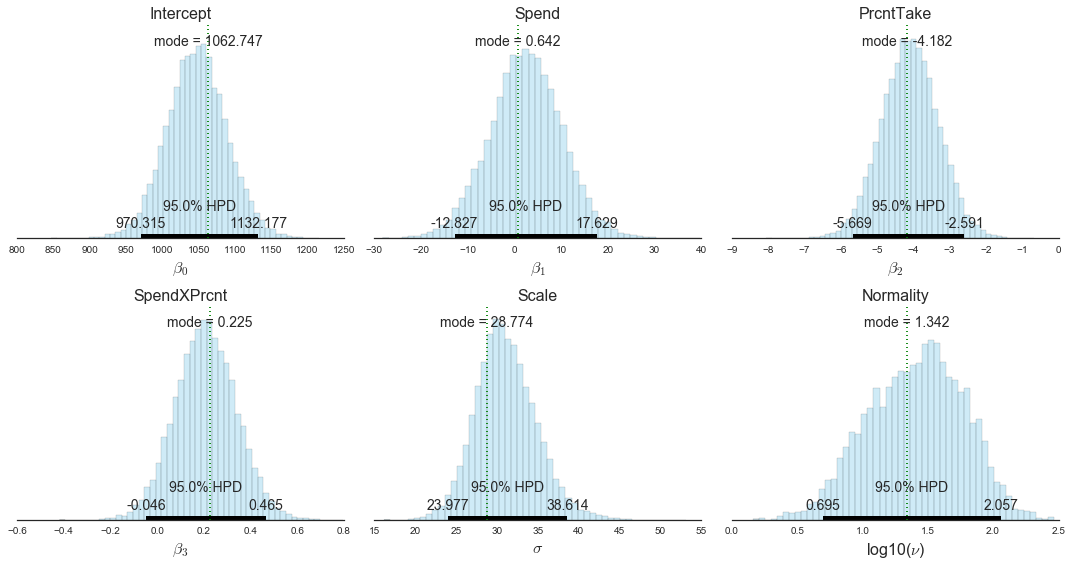

In [106]:
# Transform parameters back to original scale
beta0 = trace3['zbeta0']*scaley + meany - np.sum(trace3['zbetaj']*meanx3/scalex3, axis=1)*scaley
betaj = (trace3['zbetaj']/scalex3)*scaley
scale = trace3['zsigma']*scaley

intercept = beta0
spend = betaj[:,0]
prcnttake =  betaj[:,1]
spendxprcnt =  betaj[:,2]
normality = np.log10(trace3['nu'])
burnin = 200

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(15,8))

plot_posterior(intercept[burnin:], ax=ax1)
ax1.set_title('Intercept', fontdict=f_dict)
ax1.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(spend[burnin:], ax=ax2)
ax2.set_title('Spend', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_1$', fontdict=f_dict)

plot_posterior(prcnttake[burnin:], ax=ax3)
ax3.set_title('PrcntTake', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_2$', fontdict=f_dict)

plot_posterior(spendxprcnt[burnin:], ax=ax4)
ax4.set_title('SpendXPrcnt', fontdict=f_dict)
ax4.set_xlabel(r'$\beta_3$', fontdict=f_dict)

plot_posterior(scale[burnin:], ax=ax5)
ax5.set_title('Scale', fontdict=f_dict)
ax5.set_xlabel(r'$\sigma$', fontdict=f_dict)

plot_posterior(normality[burnin:], ax=ax6)
ax6.set_title('Normality', fontdict=f_dict)
ax6.set_xlabel(r'log10($\nu$)', fontdict=f_dict)

plt.tight_layout()

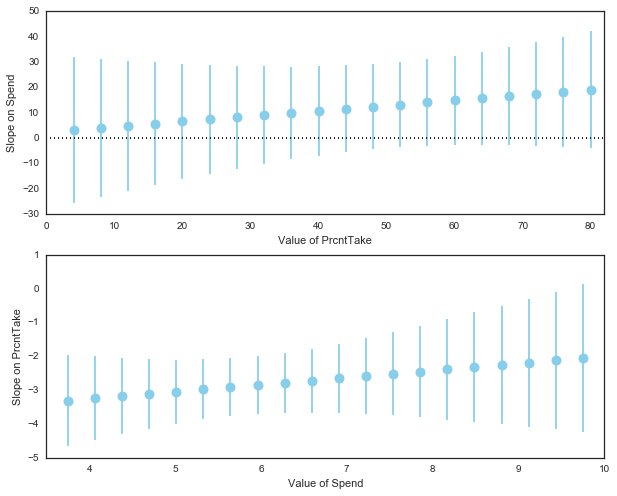

In [118]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Slope on Spend
prcnttake_values = np.linspace(4, 80, 20).reshape(1,-1)
spend_slope = spend[burnin:].reshape(-1,1) + spendxprcnt[burnin:].reshape(-1,1)*prcnttake_values
hpds = pmc.hpd(spend_slope)
spend_slope_medians = np.mean(spend_slope, axis=0)

ax1.errorbar(prcnttake_values.ravel(), spend_slope_medians, yerr=hpds[:,1]-hpds[:,0],
             color=color, linestyle='None', marker='o', markersize=10)
ax1.axhline(linestyle='dotted', color='k')
ax1.set_xlim(0,82)
ax1.set(xlabel='Value of PrcntTake', ylabel='Slope on Spend')

# Slope on PrcntTake
spend_values = np.linspace(3.75, 9.75, 20)
prcnttake_slope = prcnttake[burnin:].reshape(-1,1) + spendxprcnt[burnin:].reshape(-1,1)*spend_values
hpds2 = pmc.hpd(prcnttake_slope)
prcnttake_slope_medians = np.mean(prcnttake_slope, axis=0)

ax2.errorbar(spend_values.ravel(), prcnttake_slope_medians, yerr=hpds2[:,1]-hpds2[:,0],
             color=color, linestyle='None', marker='o', markersize=10)
ax2.set_xlim(3.5,10)
ax2.set(xlabel='Value of Spend', ylabel='Slope on PrcntTake');

### 18.3 - Shrinkage of Regression Coefficients

In *`R`* I ran the first 46 lines of code in the script `Jags-Ymet-XmetMulti-MrobustShrink-Example.R` to generate the exact same data used in the book. I exported the resulting data frame `myData` to a csv file.

In [119]:
df_shrink = pd.read_csv('data/18_3shrinkage.csv')
df_shrink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
State        50 non-null object
Spend        50 non-null float64
StuTeaRat    50 non-null float64
Salary       50 non-null float64
PrcntTake    50 non-null int64
SATV         50 non-null int64
SATM         50 non-null int64
SATT         50 non-null int64
xRand1       50 non-null float64
xRand2       50 non-null float64
xRand3       50 non-null float64
xRand4       50 non-null float64
xRand5       50 non-null float64
xRand6       50 non-null float64
xRand7       50 non-null float64
xRand8       50 non-null float64
xRand9       50 non-null float64
xRand10      50 non-null float64
xRand11      50 non-null float64
xRand12      50 non-null float64
dtypes: float64(15), int64(4), object(1)
memory usage: 7.9+ KB


In [254]:
# Select the predictor columns: Spend, PrcntTake and the 12 randonly generated predictors
X4 = df_shrink.iloc[:, np.r_[[1,4], np.arange(8,20)]]
y4 = df_shrink.SATT

meanx4 = X4.mean().values
scalex4 = X4.std().values
zX4 = ((X4-meanx4)/scalex4).values

meany4 = y4.mean()
scaley4 = y4.std()
zy4 = ((y4-meany4)/scaley4).values

##### Hierarchical model with fixed, independent, vague normal priors

#### Model (Kruschke, 2015)

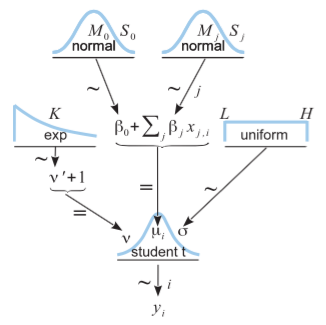

In [281]:
Image('images/fig18_4.png', width=400)

In [171]:
with pmc.Model() as model4:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(zX4.shape[1]))
    zmu =  zbeta0 + pmc.dot(zbetaj, zX4.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy4)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [172]:
with model4:
    trace4 = pmc.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 5000 of 5000 complete in 30.1 sec

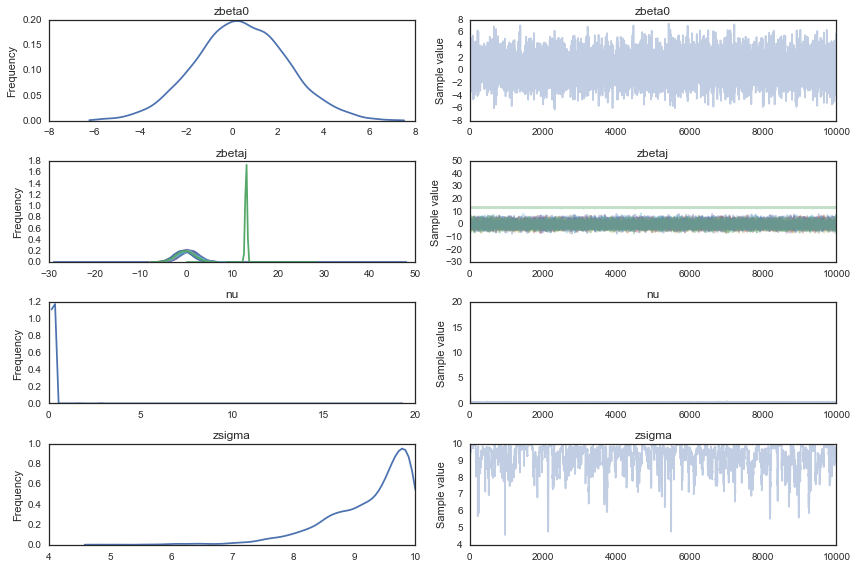

In [160]:
pmc.traceplot(trace4);

Index(['xRand1', 'xRand2'], dtype='object')

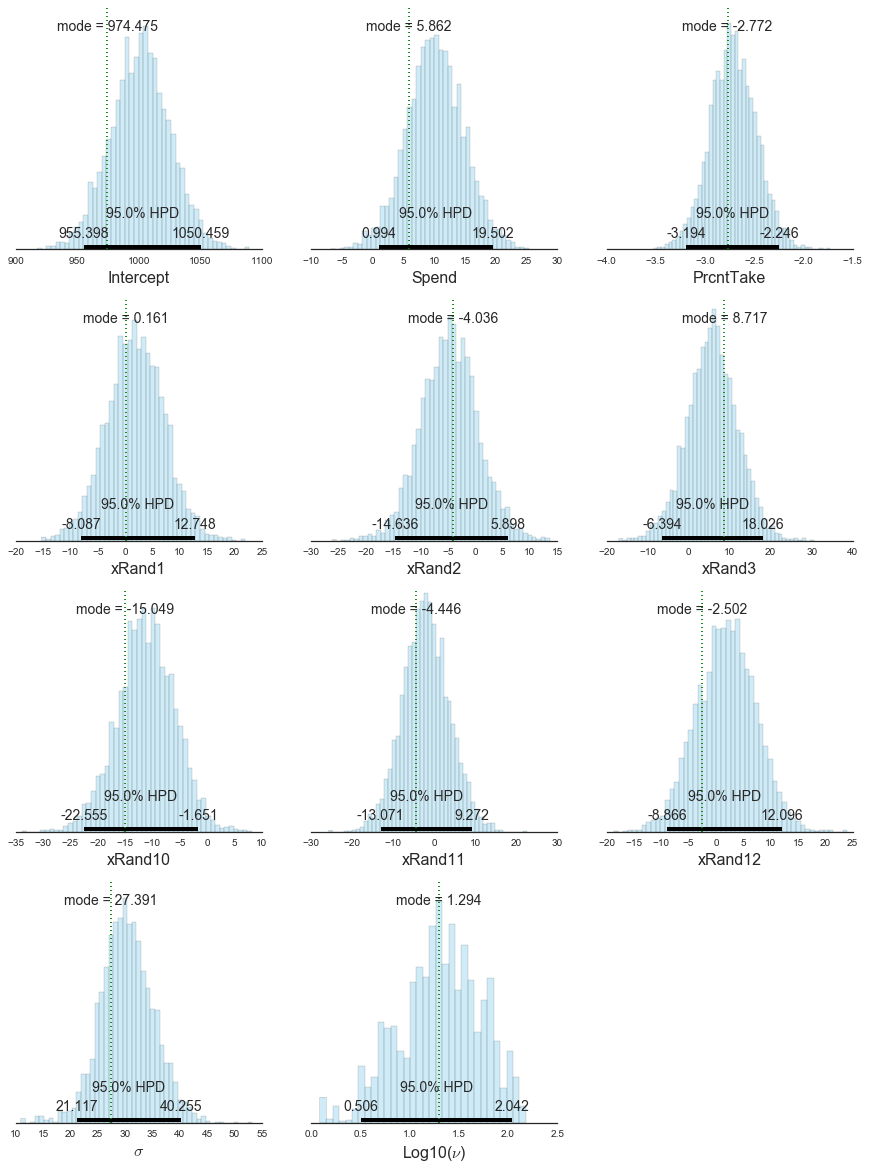

In [473]:
# Transform parameters back to original scale
beta0 = trace4['zbeta0']*scaley4 + meany4 - np.sum(trace4['zbetaj']*meanx4/scalex4, axis=1)*scaley4
betaj = (trace4['zbetaj']/scalex4)*scaley4
scale = trace4['zsigma']*scaley4

intercept = beta0
spend = betaj[:,0]
prcnttake =  betaj[:,1]
normality = np.log10(trace3['nu'])
burnin = 200

fig, axes = plt.subplots(4,3, figsize=(15,20))

# Intercept
plot_posterior(intercept, burnin=burnin, ax=axes.flatten()[0])
axes.flatten()[0].set_xlabel('Intercept', fontdict=f_dict)

# Spend & PrcntTale
plot_posterior(spend, burnin=burnin, ax=axes.flatten()[1])
axes.flatten()[1].set_xlabel('Spend', fontdict=f_dict)
plot_posterior(prcnttake, burnin=burnin, ax=axes.flatten()[2])
axes.flatten()[2].set_xlabel('PrcntTake', fontdict=f_dict)

# Randomly generated predictors
X4.columns[2:]
for ax, j in enumerate([2,3,4,11,12,13]):
    plot_posterior(betaj[:,j], burnin=burnin, ax=axes.flatten()[ax+3])
    axes.flatten()[ax+3].set_xlabel(X4.columns[j], fontdict=f_dict)

# Scale
plot_posterior(scale, burnin=burnin, ax=axes.flatten()[9])
axes.flatten()[9].set_xlabel(r'$\sigma$', fontdict=f_dict)

# Normality
plot_posterior(np.log10(trace4['nu']), burnin=burnin, ax=axes.flatten()[10])
axes.flatten()[10].set_xlabel(r'Log10($\nu$)', fontdict=f_dict);

axes.flatten()[11].set_visible(False)

##### Hierarchical model with shrinkage

#### Model (Kruschke, 2015)

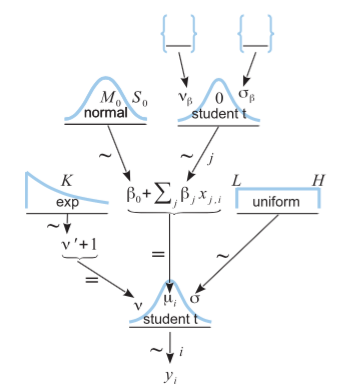

In [282]:
Image('images/fig18_10.png', width=400)

In [185]:
with pmc.Model() as model5:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    
    sigmab = pmc.Gamma('sigmab', mu=1., sd=1.) 
    zbetaj = pmc.StudentT('zbetaj', nu=1, mu=0, sd=sigmab, shape=(zX4.shape[1]))
    zmu =  zbeta0 + pmc.dot(zbetaj, zX4.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy4)

Applied log-transform to sigmab and added transformed sigmab_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [284]:
with model5:
    trace5 = pmc.sample(10000)

Assigned NUTS to zbeta0
Assigned NUTS to sigmab_log_
Assigned NUTS to zbetaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 166.2 sec

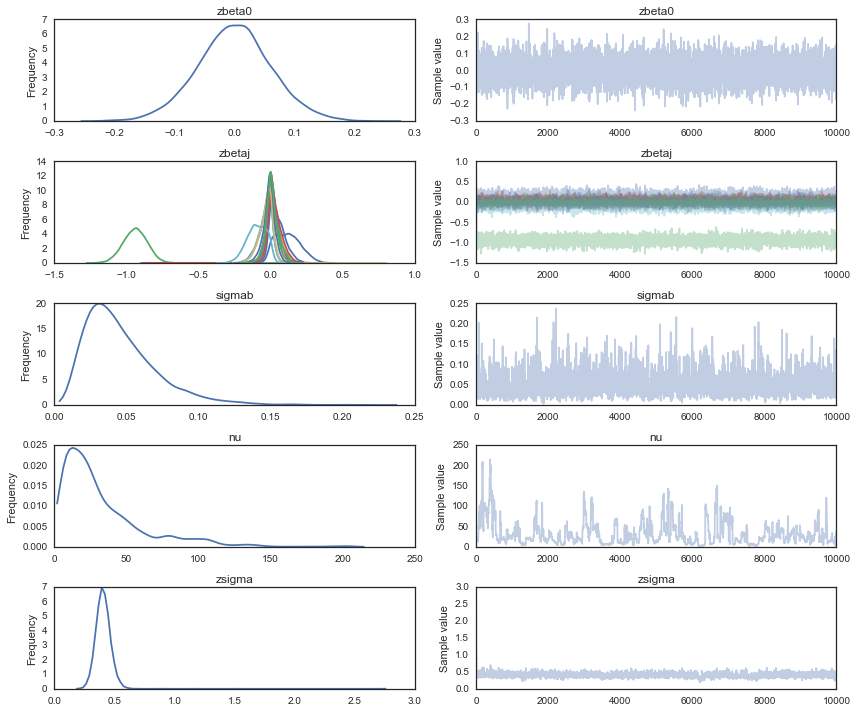

In [285]:
pmc.traceplot(trace5);

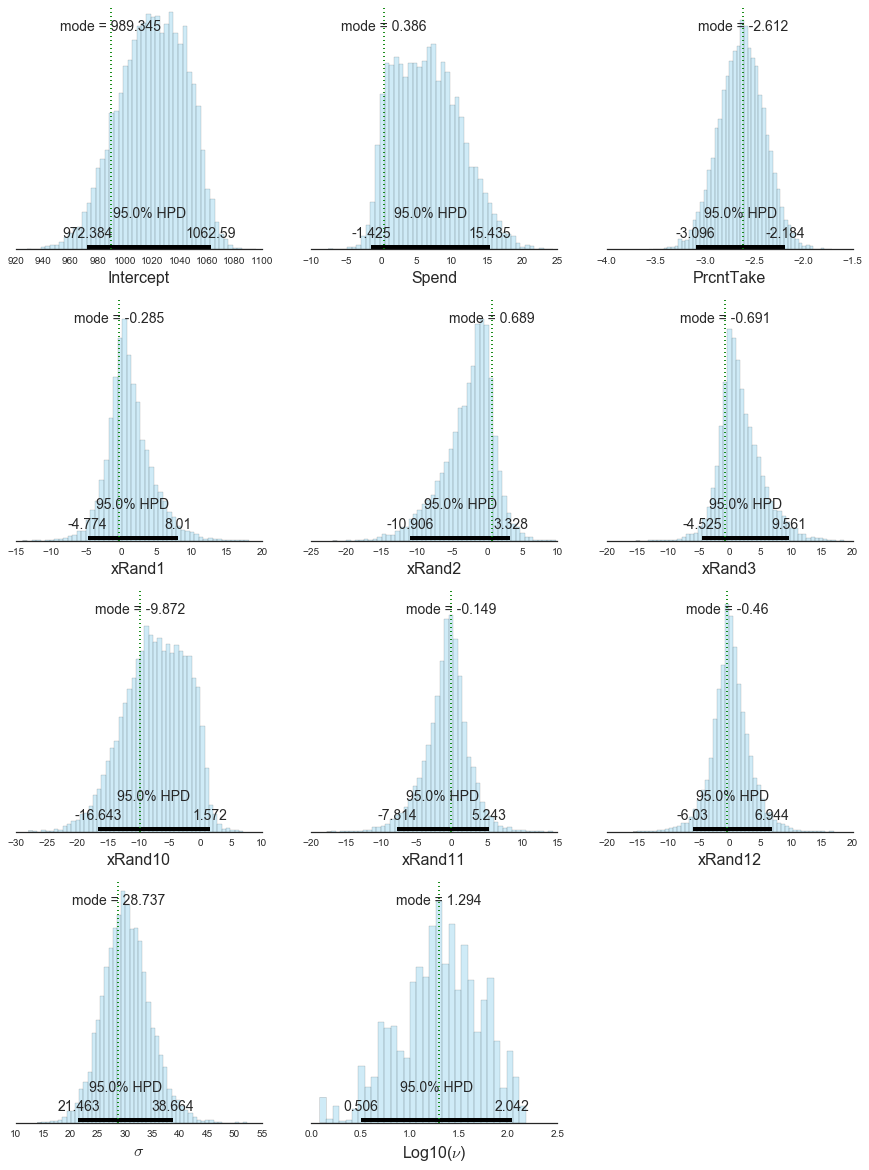

In [474]:
# Transform parameters back to original scale
beta0 = trace5['zbeta0']*scaley4 + meany4 - np.sum(trace5['zbetaj']*meanx4/scalex4, axis=1)*scaley4
betaj = (trace5['zbetaj']/scalex4)*scaley4
scale = trace5['zsigma']*scaley4

intercept = beta0
spend = betaj[:,0]
prcnttake =  betaj[:,1]
normality = np.log10(trace3['nu'])
burnin = 200

fig, axes = plt.subplots(4,3, figsize=(15,20))

# Intercept
plot_posterior(intercept, burnin=burnin, ax=axes.flatten()[0])
axes.flatten()[0].set_xlabel('Intercept', fontdict=f_dict)

# Spend & PrcntTale
plot_posterior(spend, burnin=burnin, ax=axes.flatten()[1])
axes.flatten()[1].set_xlabel('Spend', fontdict=f_dict)
plot_posterior(prcnttake, burnin=burnin, ax=axes.flatten()[2])
axes.flatten()[2].set_xlabel('PrcntTake', fontdict=f_dict)

# Randomly generated predictors
X4.columns[2:]
for ax, j in enumerate([2,3,4,11,12,13]):
    plot_posterior(betaj[:,j], burnin=burnin, ax=axes.flatten()[ax+3])
    axes.flatten()[ax+3].set_xlabel(X4.columns[j], fontdict=f_dict)

# Scale
plot_posterior(scale, burnin=burnin, ax=axes.flatten()[9])
axes.flatten()[9].set_xlabel(r'$\sigma$', fontdict=f_dict)

# Normality
plot_posterior(np.log10(trace4['nu']), burnin=burnin, ax=axes.flatten()[10])
axes.flatten()[10].set_xlabel(r'Log10($\nu$)', fontdict=f_dict);

axes.flatten()[11].set_visible(False)

### 18.4 - Variable Selection

#### sd = 2

In [287]:
with pmc.Model() as model6:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2.)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2., shape=(zX.shape[1]))
    deltaj = pmc.Bernoulli('deltaj', 0.5, shape=(zX.shape[1]))
    
    zmu =  zbeta0 + pmc.dot(deltaj*zbetaj, zX.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [288]:
with model6:
    trace6 = pmc.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 5000 of 5000 complete in 52.8 sec

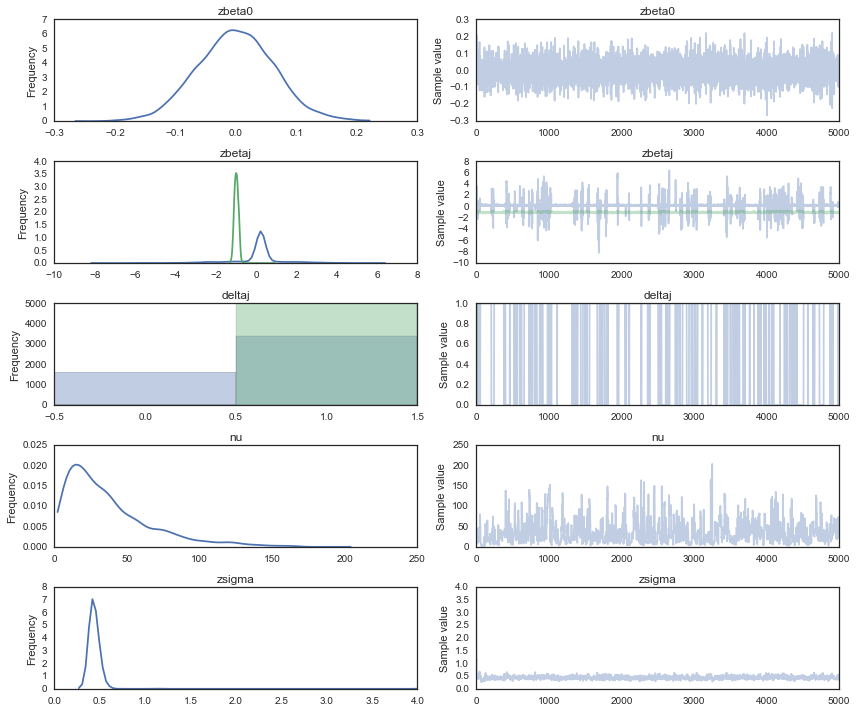

In [289]:
pmc.traceplot(trace6);

In [423]:
def plot_models(trace, burnin=200):

    # Transform parameters back to original scale
    beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['deltaj']*trace['zbetaj']*meanx/scalex, axis=1)*scaley
    betaj = (trace['deltaj']*trace['zbetaj']/scalex)*scaley
    scale = trace['zsigma']*scaley

    # Get the indexes and probabilities of the two models: full model and model with just prcnttake
    full_model_idx = np.where(np.equal(trace['deltaj'], (1,1)).all(axis=1))
    full_model_prob = np.sum(np.equal(trace['deltaj'], (1,1)).all(axis=1))/len(trace[trace.varnames[0]])
    prcnttake_model_idx = np.where(np.equal(trace['deltaj'], (0,1)).all(axis=1))
    prcnttake_model_prob = np.sum(np.equal(trace['deltaj'], (0,1)).all(axis=1))/len(trace[trace.varnames[0]])

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
    fig.suptitle('Model Prob = {}'.format(full_model_prob), fontsize=20)
    plot_posterior(beta0[full_model_idx], point_est='mean', burnin=burnin, ax=ax1)
    ax1.set_xlabel('Intercept', fontdict=f_dict)
    plot_posterior(betaj[full_model_idx,0].ravel(), point_est='mean', burnin=burnin, ax=ax2)
    ax2.set_xlabel('Spend', fontdict=f_dict)
    plot_posterior(betaj[full_model_idx,1].ravel(), point_est='mean', burnin=burnin, ax=ax3)
    ax3.set_xlabel('PrcntTake', fontdict=f_dict)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
    fig.suptitle('Model Prob = {}'.format(prcnttake_model_prob), fontsize=20)
    plot_posterior(beta0[prcnttake_model_idx], point_est='mean', burnin=burnin, ax=ax1)
    ax1.set_xlabel('Intercept', fontdict=f_dict)
    plot_posterior(betaj[prcnttake_model_idx,1].ravel(), point_est='mean', burnin=burnin, ax=ax3)
    ax3.set_xlabel('PrcntTake', fontdict=f_dict)
    ax2.set_visible(False);

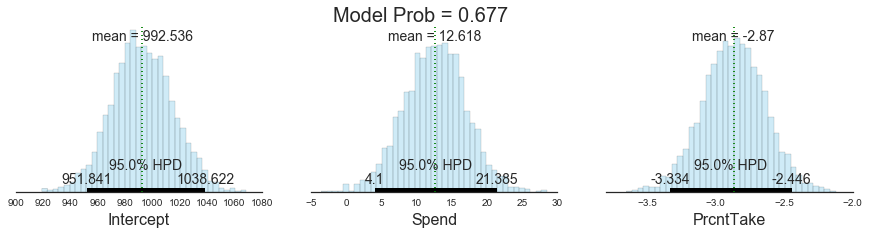

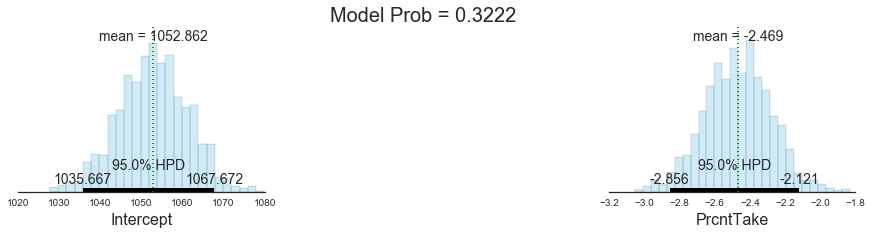

In [424]:
plot_models(trace6)

#### sd = 1

In [355]:
with pmc.Model() as model7:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=1.)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=1., shape=(zX.shape[1]))
    deltaj = pmc.Bernoulli('deltaj', 0.5, shape=(zX.shape[1]))
    
    zmu =  zbeta0 + pmc.dot(deltaj*zbetaj, zX.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [356]:
with model7:
    trace7 = pmc.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 5000 of 5000 complete in 48.7 sec

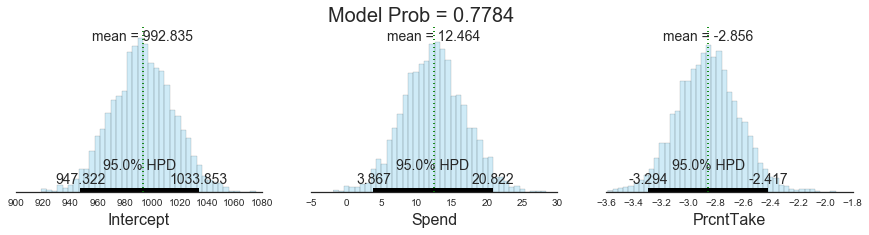

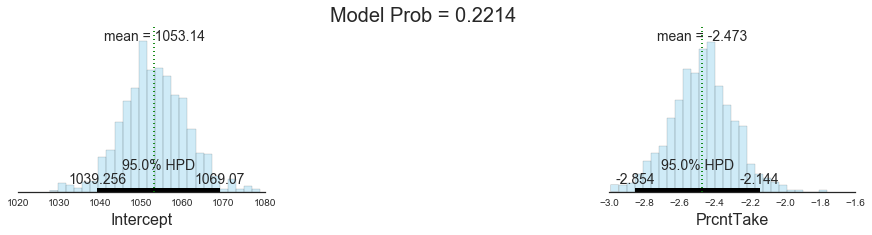

In [425]:
plot_models(trace7)

#### sd = 10

In [357]:
with pmc.Model() as model8:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=10.)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=10., shape=(zX.shape[1]))
    deltaj = pmc.Bernoulli('deltaj', 0.5, shape=(zX.shape[1]))
    
    zmu =  zbeta0 + pmc.dot(deltaj*zbetaj, zX.T)
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [359]:
with model8:
    trace8 = pmc.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 5000 of 5000 complete in 93.7 sec

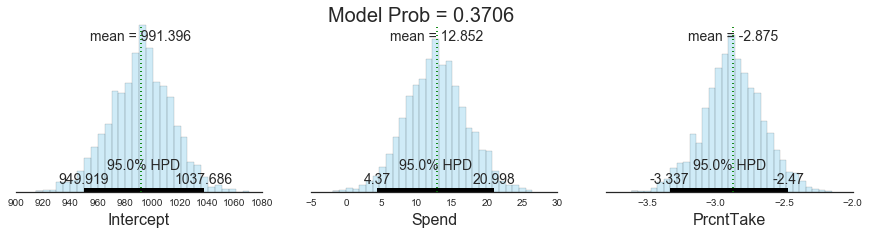

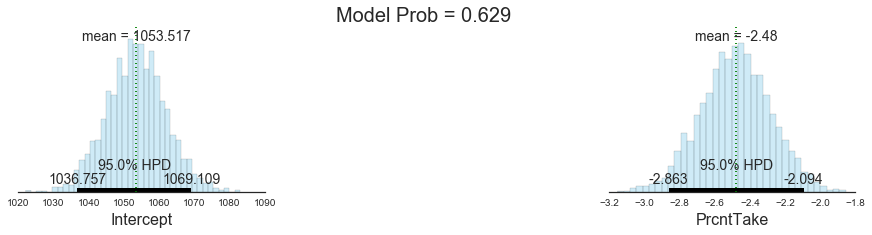

In [426]:
plot_models(trace8)

### 18.4.2 - Variable Selection with hierarchical shrinkage

In [365]:
X5 = df[['Spend', 'PrcntTake', 'StuTeaRat', 'Salary']]
X5.corr()

              Spend  PrcntTake  StuTeaRat    Salary
Spend      1.000000   0.592627  -0.371025  0.869802
PrcntTake  0.592627   1.000000  -0.213054  0.616780
StuTeaRat -0.371025  -0.213054   1.000000 -0.001146
Salary     0.869802   0.616780  -0.001146  1.000000

In [366]:
meanx5 = X5.mean().values
scalex5 = X5.std().values
zX5 = ((X5-meanx5)/scalex5).values

In [368]:
with pmc.Model() as model9:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    
    sigmab = pmc.Gamma('sigmab', alpha=1.1051, beta=0.1051) 
    zbetaj = pmc.StudentT('zbetaj', nu=1, mu=0, sd=sigmab, shape=(zX5.shape[1]))
    deltaj = pmc.Bernoulli('deltaj', 0.5, shape=(zX5.shape[1]))
    
    zmu =  zbeta0 + pmc.dot(deltaj*zbetaj, zX5.T)
        
    nu = pmc.Exponential('nu', 1/30.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)     

Applied log-transform to sigmab and added transformed sigmab_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [420]:
with model9:
    trace9 = pmc.sample(10000)

Assigned NUTS to zbeta0
Assigned NUTS to sigmab_log_
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 628.7 sec

In [460]:
def plot_models2(trace, model):

    # Transform parameters back to original scale
    beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['deltaj']*trace['zbetaj']*meanx5/scalex5, axis=1)*scaley
    betaj = (trace['deltaj']*trace['zbetaj']/scalex5)*scaley
    scale = trace['zsigma']*scaley

    # Get the indexes and probabilities of the model
    model_idx = np.where(np.equal(trace['deltaj'], model).all(axis=1))
    model_prob = np.sum(np.equal(trace['deltaj'], model).all(axis=1))/len(trace[trace.varnames[0]])
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(15,3))
    
    fig.suptitle('Model Prob = {}'.format(model_prob), fontsize=20)
    plot_posterior(beta0[model_idx], point_est='mean', burnin=burnin, ax=ax1)
    ax1.set_xlabel('Intercept', fontdict=f_dict)
    plot_posterior(betaj[model_idx,0].ravel(), point_est='mean', burnin=burnin, ax=ax2)
    ax2.set_xlabel('Spend', fontdict=f_dict)
    plot_posterior(betaj[model_idx,1].ravel(), point_est='mean', burnin=burnin, ax=ax3)
    ax3.set_xlabel('PrcntTake', fontdict=f_dict)
    plot_posterior(betaj[model_idx,2].ravel(), point_est='mean', burnin=burnin, ax=ax4)
    ax4.set_xlabel('StuTeaRate', fontdict=f_dict)
    plot_posterior(betaj[model_idx,3].ravel(), point_est='mean', burnin=burnin, ax=ax5)
    ax5.set_xlabel('Salary', fontdict=f_dict)
    
    # Only show posteriors for predictors that are part of the model
    for ax, m in zip([ax2, ax3, ax4, ax5], model):
        ax.set_visible(bool(m))

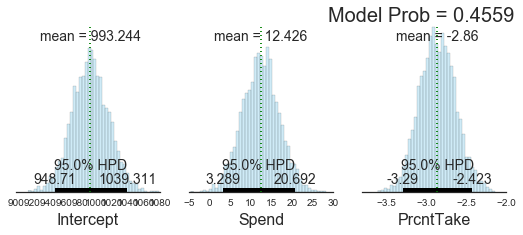

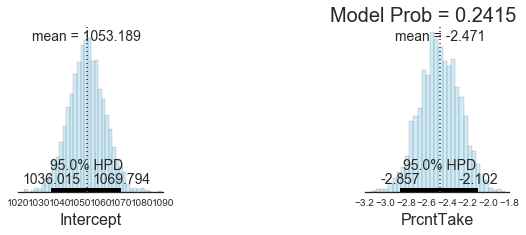

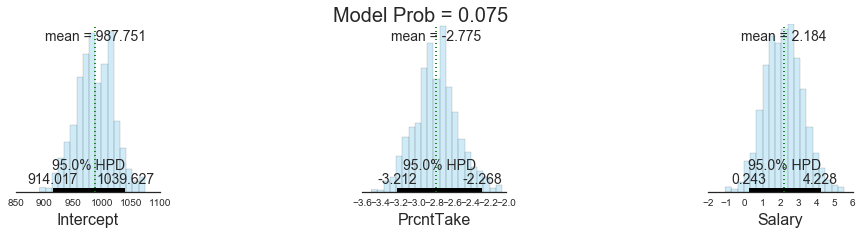

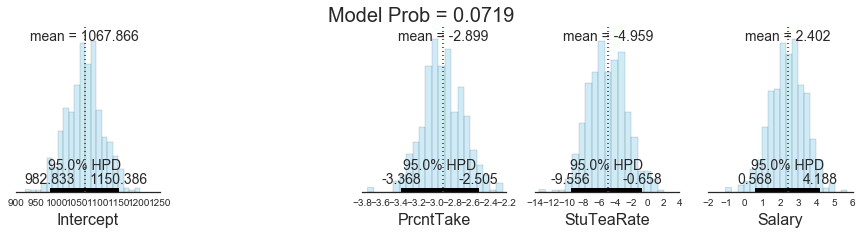

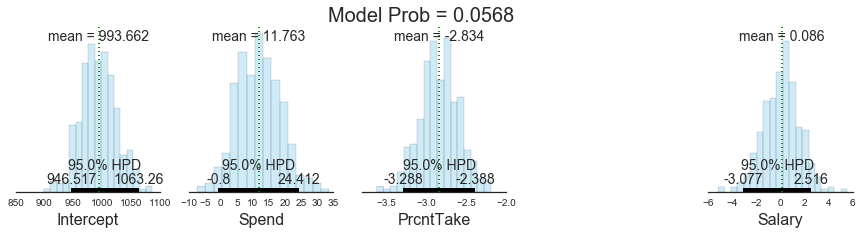

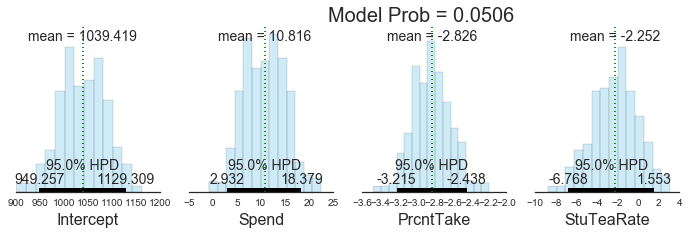

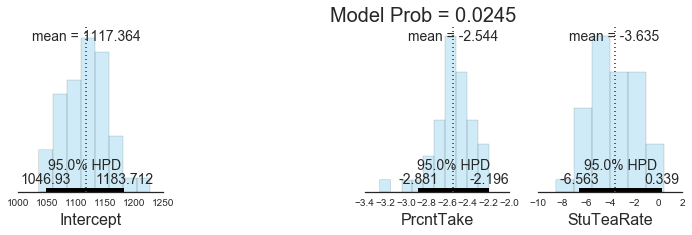

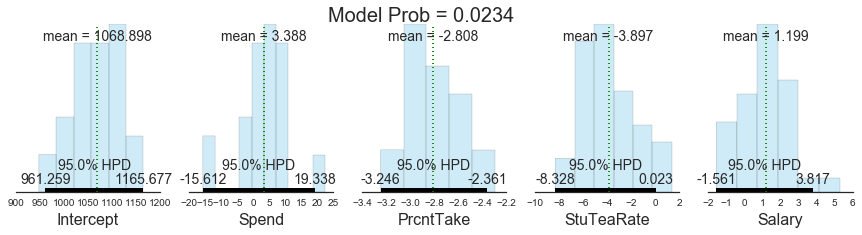

In [461]:
# Encode 8 models with different sets of predictors in a list of tuples
models = [(1,1,0,0),
         (0,1,0,0),
         (0,1,0,1),
         (0,1,1,1),
         (1,1,0,1),
         (1,1,1,0),
         (0,1,1,0),
         (1,1,1,1,)]

[plot_models2(trace9, m) for m in models];